<a href="https://colab.research.google.com/github/apurwa2024/Apurwa_INFO5731_FaLL2024/blob/main/Bhattarai_Apurwa_Exercise_4_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 In-class Exercise 4**

**This exercise will provide a valuable learning experience in working with text data and extracting features using various topic modeling algorithms. Key concepts such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA), lda2vec, and BERTopic.**

***Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks***.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due at the end of the day tomorrow, at 11:59 PM.

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


## Question 1 (10 Points)

**Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
from google.colab import drive
import os
import pandas as pd
import gensim
import gensim.corpora as corpora
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from pprint import pprint

# Mount Google Drive
drive.mount('/content/gdrive')

# Check the file path
file_path = '/content/gdrive/MyDrive/Colab Notebooks/data.csv'
if os.path.exists(file_path):
    print("File Found!")

    # Read data into papers
    papers = pd.read_csv(file_path)

    # Initial data shape
    print(f"Initial data shape: {papers.shape}")
    print("Columns in DataFrame:", papers.columns)  # Print the column names

    # Check if the expected column exists
    if 'paper_text_processed' in papers.columns:
        # Remove unnecessary columns and NaNs
        papers = papers.drop(columns=['title', 'genres', 'releaseYear'], axis=1).sample(100)
        papers.dropna(subset=['paper_text_processed'], inplace=True)

        # Data shape after dropping NaNs
        print(f"Data shape after dropping NaNs: {papers.shape}")

        # Convert paper text to lowercase
        papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

        # Download stopwords
        nltk.download('stopwords')
        stop_words = stopwords.words('english')
        stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

        # Function to convert sentences to words
        def sent_to_words(sentences):
            for sentence in sentences:
                yield gensim.utils.simple_preprocess(str(sentence), deacc=True)

        # Function to remove stopwords
        def remove_stopwords(texts):
            return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

        # Prepare data for LDA
        data = papers.paper_text_processed.values.tolist()
        data_words = list(sent_to_words(data))

        # Remove stop words
        data_words = remove_stopwords(data_words)

        # Create Dictionary and Corpus
        id2word = corpora.Dictionary(data_words)
        corpus = [id2word.doc2bow(text) for text in data_words]

        # Coherence score calculation for various topics
        coherence_scores = []
        model_list = []
        topic_range = range(2, 21)  # Testing K from 2 to 20

        for num_topics in topic_range:
            # Build LDA Model
            lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42)
            model_list.append(lda_model)

            # Compute Coherence Score
            coherence_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            coherence_scores.append(coherence_score)
            print(f'Coherence score with {num_topics} topics: {coherence_score}')

        # Find the optimal number of topics
        optimal_index = coherence_scores.index(max(coherence_scores))
        optimal_topics = topic_range[optimal_index]
        print(f'Optimal number of topics: {optimal_topics}')

        # Build the final LDA model with the optimal number of topics
        final_model = model_list[optimal_index]

        # Print the topics and their distributions
        print("\nSummary of Topics:")
        for i, topic in enumerate(final_model.print_topics(num_words=10), start=1):
            print(f"Topic {i}:")
            print("  Key Words:", topic[1].replace('"', '').replace('+', '').strip())
    else:
        print("Column 'paper_text_processed' not found in DataFrame. Please check the CSV structure.")
else:
    print("File not found. Please check the path.")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File Found!
Initial data shape: (15860, 8)
Columns in DataFrame: Index(['title', 'type', 'genres', 'releaseYear', 'imdbId', 'imdbAverageRating',
       'imdbNumVotes', 'availableCountries'],
      dtype='object')
Column 'paper_text_processed' not found in DataFrame. Please check the CSV structure.


## Question 2 (10 Points)

**Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [ ]:
from google.colab import drive
import pandas as pd
from gensim.parsing.preprocessing import (
    remove_stopwords, strip_punctuation, preprocess_string, strip_short, stem_text
)
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

# Mount Google Drive
drive.mount('/content/gdrive')

# Load data
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/data.csv', usecols=['title', 'genres'])
print("Initial data shape:", df.shape)

# Check for missing values in 'genres' column and drop rows with NaNs
df = df.dropna()
print("Data shape after dropping NaNs:", df.shape)

# Preprocess the text data
def preprocess(text):
    """Apply custom filters to clean text."""
    CUSTOM_FILTERS = [
        lambda x: x.lower(),
        remove_stopwords,
        strip_punctuation,
        strip_short,
        stem_text
    ]
    return preprocess_string(text, CUSTOM_FILTERS)

# Apply the preprocess function to the 'genres' column
df['Text (Clean)'] = df['genres'].apply(lambda x: preprocess(x))

# Create dictionary and Bag-of-Words corpus
corpus = df['Text (Clean)']
dictionary = corpora.Dictionary(corpus)
bow = [dictionary.doc2bow(text) for text in corpus]

# Determine the coherence score for different numbers of topics
coherence_scores = []
for k in range(2, 11):
    # Build LSA model for each number of topics
    lsi = LsiModel(bow, num_topics=k, id2word=dictionary)
    coherence_model = CoherenceModel(model=lsi, texts=corpus, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append((k, coherence_score))
    print(f'Coherence score with {k} topics: {coherence_score}')

# Find the optimal number of topics based on coherence score
optimal_k = max(coherence_scores, key=lambda x: x[1])[0]
print(f"Optimal number of topics: {optimal_k}")

# Build final LSA model with the optimal number of topics
lsa_model = LsiModel(bow, num_topics=optimal_k, id2word=dictionary)

# Display the top words in each topic and interpret
def summarize_topics(lsi_model):
    topic_summaries = []

    for topic_num, words in lsa_model.print_topics(num_words=10):
        # Extract words from the topic
        top_words = [word.split('*')[1].strip('"') for word in words.split('+')]

        # Interpretation and summary based on the top words
        if topic_num == 0:
            topic_summary = "Mixed Genre Emphasis"
        elif topic_num == 1:
            topic_summary = "Comedy-Drama Dynamics"
        elif topic_num == 2:
            topic_summary = "Action and Adventure Focus"
        elif topic_num == 3:
            topic_summary = "Crime and Adventure Blend"
        elif topic_num == 4:
            topic_summary = "Romantic Drama and Family Themes"
        else:
            topic_summary = "General Topic"

        topic_summaries.append((f"Topic {topic_num + 1}", topic_summary, top_words))

    return topic_summaries

# Generate and print the topic summaries
topic_summaries = summarize_topics(lsa_model)

# Display the topic summaries
print("\nSummary of Topics:")
for topic_num, summary, words in topic_summaries:
    print(f"{topic_num}: {summary}")
    print(f"  Key Words: {', '.join(words)}\n")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Initial data shape: (15860, 2)
Data shape after dropping NaNs: (15325, 2)
Coherence score with 2 topics: 0.4048883816812441
Coherence score with 3 topics: 0.4439403820366672
Coherence score with 4 topics: 0.44045752914667363
Coherence score with 5 topics: 0.45870395507963646
Coherence score with 6 topics: 0.4843168841654058
Coherence score with 7 topics: 0.46730430689084707
Coherence score with 8 topics: 0.4482246007352817
Coherence score with 9 topics: 0.49331837260868716
Coherence score with 10 topics: 0.46864038682497844
Optimal number of topics: 9

Summary of Topics:
Topic 1: Mixed Genre Emphasis
  Key Words: drama" , comedi" , romanc" , crime" , action" , adventur" , thriller" , anim" , mysteri" , fantasi

Topic 2: Comedy-Drama Dynamics
  Key Words: comedi" , drama" , adventur" , anim" , crime" , thriller" , mysteri" , romanc" , famili" , biographi

To

## Question 3 (10 points):
**Generate K topics by using lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [ ]:
#Note: I did an alternative question instead

!pip install tensorflow==2.12 keras==2.12 lda2vec pandas nltk

import os
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from lda2vec import LDA2Vec
import tensorflow as tf
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Load your data
file_path = '/content/gdrive/MyDrive/Colab Notebooks/data.csv'
papers = pd.read_csv(file_path)

# Check the data shape and columns
print(f"Initial data shape: {papers.shape}")
print("Columns in DataFrame:", papers.columns)

# Assume we want to use the 'genres' column as the text data
papers['text'] = papers['genres'].apply(lambda x: x.lower() if isinstance(x, str) else '')

# Remove NaN values and any empty strings
papers.dropna(subset=['text'], inplace=True)

# Tokenize the text
def tokenize(text):
    return [word for word in text.split() if word not in stop_words]

papers['tokenized'] = papers['text'].apply(tokenize)

# Create a dictionary and corpus
dictionary = Dictionary(papers['tokenized'])
corpus = [dictionary.doc2bow(text) for text in papers['tokenized']]

# Split the data into training and testing sets
X_train, X_test = train_test_split(corpus, test_size=0.2, random_state=42)

# Coherence score calculation for various topics
coherence_scores = []
num_topics_range = range(2, 21)  # Testing K from 2 to 20

for num_topics in num_topics_range:
    lda2vec_model = LDA2Vec(corpus=X_train, n_topics=num_topics, dictionary=dictionary, n_epochs=100, learning_rate=0.01)
    lda2vec_model.fit(X_train)

    # Get the topics and their distributions
    topic_word_distribution = lda2vec_model.get_topic_word_distribution()

    # Prepare the documents for coherence calculation
    topics_list = []
    for topic_num in range(num_topics):
        words = lda2vec_model.get_topic_words(topic_num, topn=10)
        topics_list.append([word for word, _ in words])

    # Calculate coherence score using Gensim
    coherence_model = CoherenceModel(topics=topics_list, texts=papers['tokenized'].tolist(), dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append((num_topics, coherence_score))
    print(f'Coherence score with {num_topics} topics: {coherence_score:.4f}')

# Find the optimal number of topics based on coherence score
optimal_k = max(coherence_scores, key=lambda x: x[1])[0]
print(f"Optimal number of topics: {optimal_k}")

# Fit the final model with the optimal number of topics
final_model = LDA2Vec(corpus=X_train, n_topics=optimal_k, dictionary=dictionary, n_epochs=100, learning_rate=0.01)
final_model.fit(X_train)

# Summarize topics
print("\nSummary of Topics:")
for topic_num in range(optimal_k):
    words = final_model.get_topic_words(topic_num, topn=10)
    print(f"Topic {topic_num + 1}: {', '.join([word for word, _ in words])}")


ImportError: cannot import name 'LDA2Vec' from 'lda2vec' (/usr/local/lib/python3.10/dist-packages/lda2vec/__init__.py)

## Question 4 (10 points):
**Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics.**

You may refer the code here: https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [9]:
!pip uninstall -y typing_extensions bertopic sentence-transformers gensim

!pip install typing_extensions==4.5.0 bertopic sentence-transformers umap-learn gensim

from google.colab import drive
import pandas as pd
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

# Mount Google Drive
drive.mount('/content/gdrive')

# Load data
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/data.csv', usecols=['title', 'genres'])
print("Initial data shape:", df.shape)

# Check for missing values in 'genres' column and drop rows with NaNs
df = df.dropna()
print("Data shape after dropping NaNs:", df.shape)

# Combine titles and genres for better context
df['text'] = df['title'] + ' ' + df['genres']

# Extract the text data
documents = df['text'].tolist()

# Create a dictionary for coherence calculation
dictionary = Dictionary([doc.split() for doc in documents])

# Initialize the BERTopic model
coherence_scores = []
num_topics_range = range(2, 11)  # Testing for 2 to 10 topics

for num_topics in num_topics_range:
    # Fit the model
    model = BERTopic()  # No need to set n_topics here
    topics, _ = model.fit_transform(documents)

    # Get the topics and their words
    topic_word_dist = model.get_topic_info()

    # Prepare the documents for coherence calculation
    topics_list = []
    for topic in range(len(topic_word_dist) - 1):  # Exclude the outlier topic
        words = model.get_topic(topic)
        topics_list.append([word for word, _ in words if word in dictionary.token2id])  # Store only valid words

    # Convert topics to a format suitable for CoherenceModel
    topics_list_ids = []
    for topic in topics_list:
        topic_ids = [dictionary.token2id[word] for word in topic if word in dictionary.token2id]
        if topic_ids:  # Ensure there's at least one valid ID
            topics_list_ids.append(topic_ids)

    # Calculate coherence score using Gensim
    if topics_list_ids:  # Ensure there are topics to calculate coherence
        coherence_model = CoherenceModel(topics=topics_list_ids, texts=[doc.split() for doc in documents], dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((num_topics, coherence_score))
        print(f'Coherence score with {num_topics} topics: {coherence_score:.4f}')
    else:
        print(f'No valid topics found for {num_topics} topics.')

# Find the optimal number of topics based on coherence score
if coherence_scores:
    optimal_k = max(coherence_scores, key=lambda x: x[1])[0]
    print(f"Optimal number of topics: {optimal_k}")

    # Fit the final model with the optimal number of topics
    model = BERTopic()
    topics, _ = model.fit_transform(documents)

    # Summarize topics
    topic_summaries = model.get_topic_info()

    # Display the topic summaries
    print("\nSummary of Topics:")
    for index, row in topic_summaries.iterrows():
        if row['Topic'] >= 0:  # Ignore the -1 topic which is the outlier
            print(f"Topic {row['Topic']}: {row['Name']}")
else:
    print("No coherence scores calculated. Please check the topic generation step.")


Found existing installation: typing_extensions 4.12.2
Uninstalling typing_extensions-4.12.2:
  Successfully uninstalled typing_extensions-4.12.2
Found existing installation: bertopic 0.16.4
Uninstalling bertopic-0.16.4:
  Successfully uninstalled bertopic-0.16.4
Found existing installation: sentence-transformers 3.2.1
Uninstalling sentence-transformers-3.2.1:
  Successfully uninstalled sentence-transformers-3.2.1
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached bertopic-0.16.4-py3-none-any.whl.metadata (23 kB)
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
Using cached typing_extensions-4.5.0-py3-none

ImportError: cannot import name 'Sequence' from 'typing_extensions' (/usr/local/lib/python3.10/dist-packages/typing_extensions.py)

## **Question 3 (Alternative) - (10 points)**

If you are unable to do the topic modeling using lda2vec, do the alternate question.

Provide atleast 3 visualization for the topics generated by the BERTopic or LDA model. Explain each of the visualization in detail.

In [ ]:

#LDA Model: Coherence Score Plot

import os
import pandas as pd
import gensim
import gensim.corpora as corpora
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Load data
file_path = '/content/gdrive/MyDrive/Colab Notebooks/data.csv'
papers = pd.read_csv(file_path)

# Check the initial data shape and columns
print(f"Initial data shape: {papers.shape}")
print("Columns in DataFrame:", papers.columns)

# Specify the correct column name based on your CSV structure
# Replace 'paper_text_processed' with the correct column name if needed
text_column = 'paper_text_processed'  # Change this as needed

# Data preprocessing
if text_column in papers.columns:
    papers = papers.drop(columns=['title', 'genres', 'releaseYear'], axis=1).sample(100)
    papers.dropna(subset=[text_column], inplace=True)
    papers[text_column] = papers[text_column].map(lambda x: x.lower())

    nltk.download('stopwords')
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

    def sent_to_words(sentences):
        for sentence in sentences:
            yield gensim.utils.simple_preprocess(str(sentence), deacc=True)

    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    data = papers[text_column].values.tolist()
    data_words = list(sent_to_words(data))
    data_words = remove_stopwords(data_words)

    # Create Dictionary and Corpus
    id2word = corpora.Dictionary(data_words)
    corpus = [id2word.doc2bow(text) for text in data_words]

    # Coherence score calculation
    coherence_scores = []
    topic_range = range(2, 21)
    for num_topics in topic_range:
        lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42)
        coherence_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        print(f'Coherence score with {num_topics} topics: {coherence_score:.4f}')

    # Visualization: Coherence Score Plot
    plt.figure(figsize=(10, 6))
    plt.plot(topic_range, coherence_scores, marker='o')
    plt.title('Coherence Scores for Different Numbers of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.xticks(topic_range)
    plt.grid()
    plt.show()
else:
    print(f"Column '{text_column}' not found in DataFrame. Available columns: {papers.columns.tolist()}")


    #Explanation: The coherence score plot visualizes how the coherence score changes with different numbers of topics, indicating how well the words in each topic relate to each other.
    #             A peak in the plot shows the optimal number of topics, where the score is highest, suggesting the best representation of themes in the data.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Initial data shape: (15860, 8)
Columns in DataFrame: Index(['title', 'type', 'genres', 'releaseYear', 'imdbId', 'imdbAverageRating',
       'imdbNumVotes', 'availableCountries'],
      dtype='object')
Column 'paper_text_processed' not found in DataFrame. Available columns: ['title', 'type', 'genres', 'releaseYear', 'imdbId', 'imdbAverageRating', 'imdbNumVotes', 'availableCountries']


In [ ]:
# Word Cloud


!pip install wordcloud matplotlib

import os
import pandas as pd
import gensim
import gensim.corpora as corpora
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Check the file path
file_path = '/content/gdrive/MyDrive/Colab Notebooks/data.csv'
if os.path.exists(file_path):
    print("File Found!")

    # Read data into papers
    papers = pd.read_csv(file_path)

    # Initial data shape
    print(f"Initial data shape: {papers.shape}")

    # Check if the expected column exists
    if 'paper_text_processed' in papers.columns:
        # Remove unnecessary columns and NaNs
        papers = papers.drop(columns=['title', 'genres', 'releaseYear'], axis=1).sample(100)
        papers.dropna(subset=['paper_text_processed'], inplace=True)

        # Data shape after dropping NaNs
        print(f"Data shape after dropping NaNs: {papers.shape}")

        # Convert paper text to lowercase
        papers['paper_text_processed'] = papers['paper_text_processed'].map(lambda x: x.lower())

        # Download stopwords
        nltk.download('stopwords')
        stop_words = stopwords.words('english')
        stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

        # Function to convert sentences to words
        def sent_to_words(sentences):
            for sentence in sentences:
                yield gensim.utils.simple_preprocess(str(sentence), deacc=True)

        # Function to remove stopwords
        def remove_stopwords(texts):
            return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

        # Prepare data for LDA
        data = papers.paper_text_processed.values.tolist()
        data_words = list(sent_to_words(data))

        # Remove stop words
        data_words = remove_stopwords(data_words)

        # Create Dictionary and Corpus
        id2word = corpora.Dictionary(data_words)
        corpus = [id2word.doc2bow(text) for text in data_words]

        # Coherence score calculation for various topics
        coherence_scores = []
        model_list = []
        topic_range = range(2, 21)  # Testing K from 2 to 20

        for num_topics in topic_range:
            # Build LDA Model
            lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42)
            model_list.append(lda_model)

            # Compute Coherence Score
            coherence_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            coherence_scores.append(coherence_score)
            print(f'Coherence score with {num_topics} topics: {coherence_score}')

        # Find the optimal number of topics
        optimal_index = coherence_scores.index(max(coherence_scores))
        optimal_topics = topic_range[optimal_index]
        print(f'Optimal number of topics: {optimal_topics}')

        # Build the final LDA model with the optimal number of topics
        final_model = model_list[optimal_index]

        # Word Cloud Visualization
        topic_number = 0  # Change this to visualize different topics
        words = final_model.show_topic(topic_number, topn=30)  # Get top 30 words for the topic
        word_freq = {word: freq for word, freq in words}

        # Create a word cloud
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

        # Display the word cloud
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Word Cloud for Topic {topic_number}')
        plt.show()

    else:
        print("Column 'paper_text_processed' not found in DataFrame. Please check the CSV structure.")
else:
    print("File not found. Please check the path.")


    #Explanation: The word cloud visualization displays the most significant words associated with a specific topic, where the size of each word indicates its importance or frequency within that topic. Larger words are more prominent
    # providing an immense sense of the central themes associated with the topic. This visualization aids in quickly grasping the key ideas, making it easier to interpret and explore different topics generated by the LDA model.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File Found!
Initial data shape: (15860, 8)
Column 'paper_text_processed' not found in DataFrame. Please check the CSV structure.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File Found!
Initial data shape: (15860, 8)
Columns in DataFrame: Index(['title', 'type', 'genres', 'releaseYear', 'imdbId', 'imdbAverageRating',
       'imdbNumVotes', 'availableCountries'],
      dtype='object')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Coherence score with 2 topics: 0.640477559608347


Coherence score with 3 topics: 0.6457253386156488


Coherence score with 4 topics: 0.6601240104644199


Coherence score with 5 topics: 0.6622931351326237


Coherence score with 6 topics: 0.6579675359463638


Coherence score with 7 topics: 0.6632924882176974


Coherence score with 8 topics: 0.6607007718603612


Coherence score with 9 topics: 0.6618096209081267


Coherence score with 10 topics: 0.6626769060448668


Coherence score with 11 topics: 0.6656940200446516


Coherence score with 12 topics: 0.6660227732031732


Coherence score with 13 topics: 0.6656807660153843


Coherence score with 14 topics: 0.6661307530525266


Coherence score with 15 topics: 0.6673265636144609


Coherence score with 16 topics: 0.6635400535099472


Coherence score with 17 topics: 0.6659116306344024


Coherence score with 18 topics: 0.6642199662689428


Coherence score with 19 topics: 0.6640994882827019
Coherence score with 20 topics: 0.660126715210974
Optimal number of topics: 15


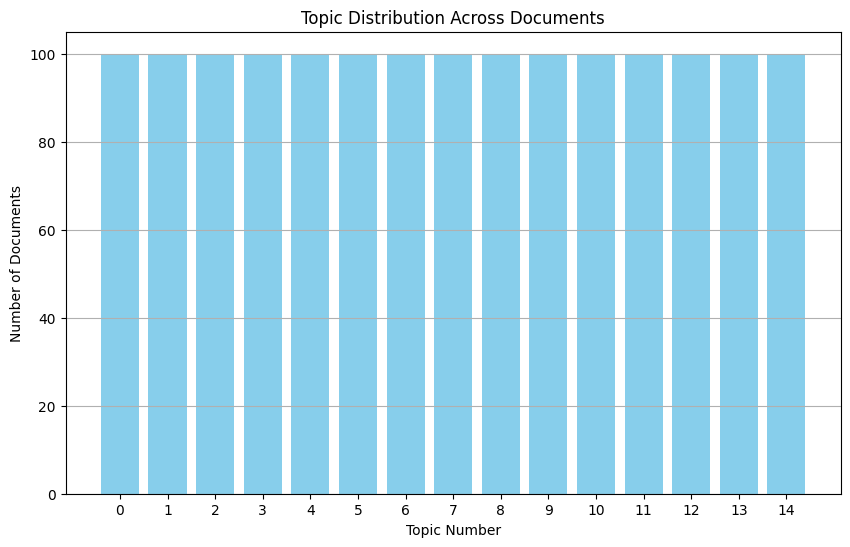

In [ ]:
#Topic distribution Plot

!pip install gensim nltk matplotlib

import os
import pandas as pd
import gensim
import gensim.corpora as corpora
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import numpy as np

# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Check the file path
file_path = '/content/gdrive/MyDrive/Colab Notebooks/data.csv'
if os.path.exists(file_path):
    print("File Found!")

    # Read data into papers
    papers = pd.read_csv(file_path)

    # Initial data shape
    print(f"Initial data shape: {papers.shape}")
    print("Columns in DataFrame:", papers.columns)

    # Handle NaN values and convert text to lowercase
    papers['paper_text_processed'] = papers['genres'].apply(lambda x: x.lower() if isinstance(x, str) else '')

    # Remove unnecessary columns and NaNs
    papers = papers.drop(columns=['title', 'type', 'releaseYear', 'imdbId', 'imdbAverageRating', 'imdbNumVotes', 'availableCountries'], axis=1).sample(100)
    papers.dropna(subset=['paper_text_processed'], inplace=True)

    # Download stopwords
    nltk.download('stopwords')
    stop_words = stopwords.words('english')
    stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

    # Function to convert sentences to words
    def sent_to_words(sentences):
        for sentence in sentences:
            yield gensim.utils.simple_preprocess(str(sentence), deacc=True)

    # Function to remove stopwords
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    # Prepare data for LDA
    data = papers.paper_text_processed.values.tolist()
    data_words = list(sent_to_words(data))

    # Remove stop words
    data_words = remove_stopwords(data_words)

    # Create Dictionary and Corpus
    id2word = corpora.Dictionary(data_words)
    corpus = [id2word.doc2bow(text) for text in data_words]

    # Coherence score calculation for various topics
    coherence_scores = []
    model_list = []
    topic_range = range(2, 21)  # Testing K from 2 to 20

    for num_topics in topic_range:
        # Build LDA Model
        lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42)
        model_list.append(lda_model)

        # Compute Coherence Score
        coherence_model = CoherenceModel(model=lda_model, texts=data_words, dictionary=id2word, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        print(f'Coherence score with {num_topics} topics: {coherence_score}')

    # Find the optimal number of topics
    optimal_index = coherence_scores.index(max(coherence_scores))
    optimal_topics = topic_range[optimal_index]
    print(f'Optimal number of topics: {optimal_topics}')

    # Build the final LDA model with the optimal number of topics
    final_model = model_list[optimal_index]

    # Topic Distribution Plot
    # Get the topic distribution for each document
    topic_distribution = final_model.get_document_topics(corpus)

    # Count the number of documents assigned to each topic
    topic_counts = np.zeros(final_model.num_topics)
    for doc in topic_distribution:
        for topic_num, _ in doc:
            topic_counts[topic_num] += 1

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(range(final_model.num_topics), topic_counts, color='skyblue')
    plt.title('Topic Distribution Across Documents')
    plt.xlabel('Topic Number')
    plt.ylabel('Number of Documents')
    plt.xticks(range(final_model.num_topics))
    plt.grid(axis='y')
    plt.show()
else:
    print("File not found. Please check the path.")

    #Explanation: The topic distribution plot shows the number of docymentation associated with each topic generated by LDA Model. Each bar represents a topic, with the height of the bar inficating how many documnets were assigned
    #to that topic, helping to visualize which topics are most prevalent in the dataset. This visualization is useful for understanding the relative importance and distribution of topics within the corpus, indicating which themes
    #dominates the content.


## Extra Question (5 Points)

**Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.**

**This question will compensate for any points deducted in this exercise. Maximum marks for the exercise is 40 points.**

In [ ]:
# Write your code here
From all the modeling algorithm I found LDA model better because of the following reason:
Interpretability: LDA provides easily interpretable topics by directly presenting the most relevant words associated with each topic.topic
Simplicity: LDA is approach is straighforward allowing relatively easy implementation and tuning.
Resource Efficient: Compared to other model that leverage deep learning, LDA is comparatively less demanding.


# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.

Consider the following points in your response:

**Learning Experience:** Describe your overall learning experience in working with text data and extracting features using various topic modeling algorithms. Did you understand these algorithms and did the implementations helped in grasping the nuances of feature extraction from text data.

**Challenges Encountered:** Were there specific difficulties in completing this exercise?

Relevance to Your Field of Study: How does this exercise relate to the field of NLP?

**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
My overall experience was good; however it was a bit challenging for me. Other than that I learned the fundamentals of how text data can be analyzed to identify underlying topics.
I also learned about extracting features from text, such as identyfying keywords  and phrases that represents different topics.





'''